<a href="https://colab.research.google.com/github/raulsomazabracho/Unsupervised-Learning/blob/main/Client_Cohort_Clusterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project we will classify clients based on the cohort analisys of their first purchase

We will use a retail dataset from the UK

# Import Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Import Dataset

In [4]:
online = pd.read_excel('/content/drive/MyDrive/Data Science/Python/Analytics/Cohort Analysis/Online Retail.xlsx',dtype ={'CustomerID':str})
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


We will base our study with the columns of ID, date and price

# Cleaning the Dataset

## Assign acquisition month cohort

In [5]:
# Function that return the month
def get_month(x): return dt.datetime(x.year,x.month,1)

In [6]:
# Use te function above to get the month 
online['InvoiceMonth'] = online['InvoiceDate'].apply(get_month)

#Groupby month 
grouping = online.groupby('CustomerID')['InvoiceMonth']
online['CohortMonth'] = grouping.transform('min')
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01


## Extract Integer Data From Values

In [7]:
#Create a function that allow us to extract the values
def get_date_int(df,column):
  year = df[column].dt.year
  month = df[column].dt.month 
  day = df[column].dt.day
  return year, month,day

### Calculate the time between our first transaction and any transaction

In [8]:
# Get the integers for date parts from the InvoiceDaycolumn
invoice_year, invoice_month, invoice_day = get_date_int(online, 'InvoiceMonth')

# Get the integers for date parts from the CohortDay column
cohort_year, cohort_month, cohort_day = get_date_int(online, 'CohortMonth')

### Calculate the offset

In [9]:
# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Calculate difference in days
days_diff = invoice_day - cohort_day

# Extract the difference in days from all previous values
online['CohortIndex'] = years_diff * 12 + months_diff +1
print(online.head())

  InvoiceNo StockCode  ... CohortMonth  CohortIndex
0    536365    85123A  ...  2010-12-01          1.0
1    536365     71053  ...  2010-12-01          1.0
2    536365    84406B  ...  2010-12-01          1.0
3    536365    84029G  ...  2010-12-01          1.0
4    536365    84029E  ...  2010-12-01          1.0

[5 rows x 11 columns]


### Count monthly active users

In [10]:
grouping = online.groupby(['CohortMonth','CohortIndex'])
cohort_data = grouping['CustomerID']. apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index = 'CohortMonth',columns = 'CohortIndex', values = 'CustomerID')
print(cohort_counts)

CohortIndex   1.0    2.0    3.0    4.0   ...   10.0   11.0   12.0   13.0
CohortMonth                              ...                            
2010-12-01   948.0  362.0  317.0  367.0  ...  374.0  354.0  474.0  260.0
2011-01-01   421.0  101.0  119.0  102.0  ...  146.0  155.0   63.0    NaN
2011-02-01   380.0   94.0   73.0  106.0  ...  119.0   35.0    NaN    NaN
2011-03-01   440.0   84.0  112.0   96.0  ...   39.0    NaN    NaN    NaN
2011-04-01   299.0   68.0   66.0   63.0  ...    NaN    NaN    NaN    NaN
2011-05-01   279.0   66.0   48.0   48.0  ...    NaN    NaN    NaN    NaN
2011-06-01   235.0   49.0   44.0   64.0  ...    NaN    NaN    NaN    NaN
2011-07-01   191.0   40.0   39.0   44.0  ...    NaN    NaN    NaN    NaN
2011-08-01   167.0   42.0   42.0   42.0  ...    NaN    NaN    NaN    NaN
2011-09-01   298.0   89.0   97.0   36.0  ...    NaN    NaN    NaN    NaN
2011-10-01   352.0   93.0   46.0    NaN  ...    NaN    NaN    NaN    NaN
2011-11-01   321.0   43.0    NaN    NaN  ...    NaN

# Cohort Metrics

## Retention Rate

How many customers purchased in the subsequent months

In [11]:
# Store the first value as the size of the cohort
cohort_size = cohort_counts.iloc[:,0]

#Divide all the values by the total in the cohort
retention = cohort_counts.divide(cohort_size, axis = 0)

# We will multiply by 100 because its in percentage
#retention = retention.round(3)*100
print(retention)

CohortIndex  1.0       2.0       3.0   ...      11.0      12.0      13.0
CohortMonth                            ...                              
2010-12-01    1.0  0.381857  0.334388  ...  0.373418  0.500000  0.274262
2011-01-01    1.0  0.239905  0.282660  ...  0.368171  0.149644       NaN
2011-02-01    1.0  0.247368  0.192105  ...  0.092105       NaN       NaN
2011-03-01    1.0  0.190909  0.254545  ...       NaN       NaN       NaN
2011-04-01    1.0  0.227425  0.220736  ...       NaN       NaN       NaN
2011-05-01    1.0  0.236559  0.172043  ...       NaN       NaN       NaN
2011-06-01    1.0  0.208511  0.187234  ...       NaN       NaN       NaN
2011-07-01    1.0  0.209424  0.204188  ...       NaN       NaN       NaN
2011-08-01    1.0  0.251497  0.251497  ...       NaN       NaN       NaN
2011-09-01    1.0  0.298658  0.325503  ...       NaN       NaN       NaN
2011-10-01    1.0  0.264205  0.130682  ...       NaN       NaN       NaN
2011-11-01    1.0  0.133956       NaN  ...       Na

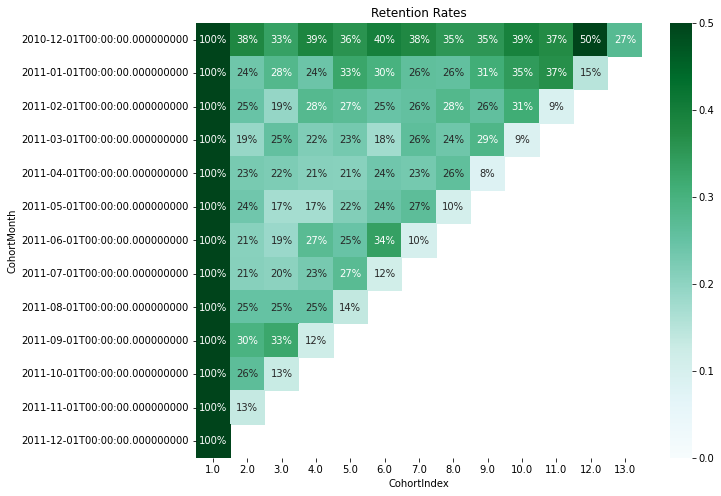

In [12]:
# Plot the Retention Rate
plt.figure(figsize =(10,8))
plt.title('Retention Rates')
sns.heatmap(data = retention, annot = True,fmt ='.0%',vmin = 0.0,vmax =0.5,cmap='BuGn')
plt.show()

## Average Quantity

In [13]:
grouping = online.groupby(['CohortMonth','CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data  = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index ='CohortMonth', columns ='CohortIndex',values = 'Quantity')
average_quantity = average_quantity.round(1)
print(average_quantity)

CohortIndex  1.0   2.0   3.0   4.0   5.0   ...  9.0   10.0  11.0  12.0  13.0
CohortMonth                                ...                              
2010-12-01   11.0  14.6  15.0  14.8  12.9  ...  16.7  16.7  17.3  12.8  14.8
2011-01-01   10.0  12.6  12.3  10.9  12.2  ...  11.4   9.9   9.1   9.5   NaN
2011-02-01   10.8  12.1  18.6  12.0  11.1  ...  10.3  11.9  12.6   NaN   NaN
2011-03-01    9.8   9.9  12.2   9.5  13.6  ...  10.5   8.9   NaN   NaN   NaN
2011-04-01    9.8  10.1   9.4  11.6  11.5  ...   7.3   NaN   NaN   NaN   NaN
2011-05-01   10.9   9.0  13.9  11.8  10.9  ...   NaN   NaN   NaN   NaN   NaN
2011-06-01   10.3  13.7  10.5  13.3  10.2  ...   NaN   NaN   NaN   NaN   NaN
2011-07-01    9.7  12.7   7.1   7.8   6.0  ...   NaN   NaN   NaN   NaN   NaN
2011-08-01    9.9   6.0   5.3   6.0   7.0  ...   NaN   NaN   NaN   NaN   NaN
2011-09-01   11.9   5.5   7.6   8.8   NaN  ...   NaN   NaN   NaN   NaN   NaN
2011-10-01    8.4   6.9   8.0   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN

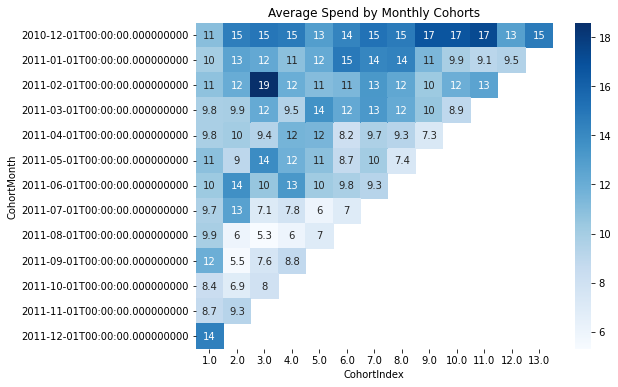

In [14]:
plt.figure(figsize=(8, 6))
plt.title('Average Spend by Monthly Cohorts')
sns.heatmap(average_quantity, annot=True, cmap='Blues')
plt.show()

# RFM Segmentation

Recency, frequency and monetary segmentation

## Grouping by percentiles

## Preprocess the data

In [15]:
#Create a total_sum column = Qunatity x UnitPrice
online['TotalSum'] = online['Quantity']*online['UnitPrice']

In [16]:
#We create a hypothetical shanpshot_data as if we are doing a recent analysis
snapshot_date = max(online.InvoiceDate) + dt.timedelta(days =1)

In [17]:
#Calculate the metrics
datamart = online.groupby(['CustomerID']).agg({
    'InvoiceDate':lambda x: (snapshot_date -x.max()).days,
    'InvoiceNo':'count',
    'TotalSum':'sum'
})

#Rename the columns
datamart.rename(columns = {'InvoiceDate':'Recency','InvoiceNo': 'Frequency','TotalSum':'MonetaryValue'}, inplace = True)
datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,2,0.00
12347,2,182,4310.00
12348,75,31,1797.24
12349,19,73,1757.55
12350,310,17,334.40


## Calculate Quantiles

In [18]:
#If its more recent the value is higher
r_labels = range(4, 0,-1)
r_quartiles = pd.qcut(datamart['Recency'], 4, labels = r_labels)
datamart = datamart.assign(R = r_quartiles.values)

In [19]:
f_labels = range(1,5)
f_quartiles = pd.qcut(datamart['Frequency'], 4, labels = f_labels)
datamart = datamart.assign(F = f_quartiles.values)


In [20]:
m_labels = range(1,5)
m_quartiles = pd.qcut(datamart['MonetaryValue'], 4, labels = m_labels)
datamart = datamart.assign(M = m_quartiles.values)

In [21]:
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12346,326,2,0.00,1,1,1
12347,2,182,4310.00,4,4,4
12348,75,31,1797.24,2,2,4
12349,19,73,1757.55,3,3,4
12350,310,17,334.40,1,1,2


## Build the scores for each segment

In [47]:
#We concatenate the 3 metrics using a function
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)

In [48]:
#We sum the 3 metrics to get a score
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)

In [49]:
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,General_Segment
CustomerID,,,,,,,,,
12346,326,2,0.00,1,1,1,111,3,Bronze
12347,2,182,4310.00,4,4,4,444,12,Gold
12348,75,31,1797.24,2,2,4,224,8,Silver
12349,19,73,1757.55,3,3,4,334,10,Gold
12350,310,17,334.40,1,1,2,112,4,Bronze


## Analyzing RFM Segments

In [50]:
datamart.groupby(['RFM_Segment']).size().sort_values(ascending = False)[:10]

RFM_Segment
444    471
111    392
122    209
344    206
211    181
333    176
222    173
233    164
433    156
322    126
dtype: int64

In [51]:
#Select the worst RFM segment and view top rows
datamart[datamart['RFM_Segment']== '111'][:5]

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,General_Segment
CustomerID,,,,,,,,,
12346,326,2,0.0,1,1,1,111,3,Bronze
12353,204,4,89.0,1,1,1,111,3,Bronze
12361,287,10,189.9,1,1,1,111,3,Bronze
12401,303,5,84.3,1,1,1,111,3,Bronze
12402,323,11,225.6,1,1,1,111,3,Bronze


In [52]:
#Summary metrics by RFM_Score
datamart.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean','count'] }).round(1)


Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           264.8       7.8         109.1   392
4           174.5      13.9         227.1   391
5           153.0      21.2         346.8   517
6            94.3      28.5         491.8   468
7            78.8      39.7         724.2   447
8            62.7      57.0         974.7   467
9            44.2      79.0        1369.6   411
10           31.3     115.3        1894.0   440
11           20.5     193.9        3845.7   368
12            6.7     371.8        8850.7   471

## Grouping into RFM Segments

In [53]:
#We create a function that studies the RFM and groupby
def segment_me(df):
  if df['RFM_Score'] >= 9:
    return 'Gold'
  elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
    return 'Silver'
  else:
    return 'Bronze'

In [54]:
#we apply the function
datamart['General_Segment'] = datamart.apply(segment_me, axis=1)

In [55]:
#Print the new dataframe
datamart.groupby('General_Segment').agg({
  'Recency': 'mean',
  'Frequency': 'mean',
  'MonetaryValue': ['mean','count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            219.7      10.9         168.0   783
Gold               25.2     195.1        4130.3  1690
Silver             98.9      36.1         625.8  1899

# K-Means Clustering

In [144]:
datamart_rfm = datamart[['Recency','Frequency','MonetaryValue']]
datamart_rfm = datamart_rfm.dropna(subset = ['MonetaryValue'], axis =0)

Tu use K-Means Clustering we need to make sure that the data has the same average and the same variance

In [145]:
datamart_rfm.describe()

,Recency,Frequency,MonetaryValue
count,4372.000000,4372.000000,4372.000000
mean,92.047118,93.053294,1898.459701
std,100.765435,232.471608,8219.345141
min,1.000000,1.000000,-4287.630000
25%,17.000000,17.000000,293.362500
50%,50.000000,42.000000,648.075000
75%,143.000000,102.000000,1611.725000
max,374.000000,7983.000000,279489.020000


In [146]:
datamart_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4372 entries, 12346 to 18287
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        4372 non-null   int64  
 1   Frequency      4372 non-null   int64  
 2   MonetaryValue  4372 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 136.6+ KB


## Data Pre-Processing

In [147]:
datamart_rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,2,0.00
12347,2,182,4310.00
12348,75,31,1797.24
12349,19,73,1757.55
12350,310,17,334.40


In [148]:
datamart_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4372 entries, 12346 to 18287
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        4372 non-null   int64  
 1   Frequency      4372 non-null   int64  
 2   MonetaryValue  4372 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 136.6+ KB


### Dealing with Skewed Data

In [149]:
print(datamart_rfm.skew(axis = 0))
print(datamart_rfm.kurtosis(axis = 0))

Recency           1.249665
Frequency        18.153735
MonetaryValue    21.705287
dtype: float64
Recency            0.430255
Frequency        486.226301
MonetaryValue    607.150543
dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


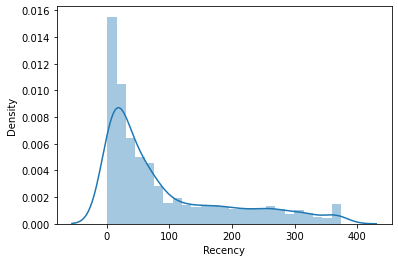

In [150]:
sns.distplot(datamart_rfm['Recency'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


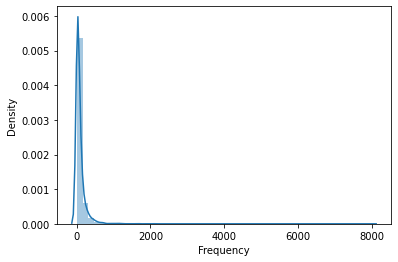

In [151]:
sns.distplot(datamart_rfm['Frequency'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


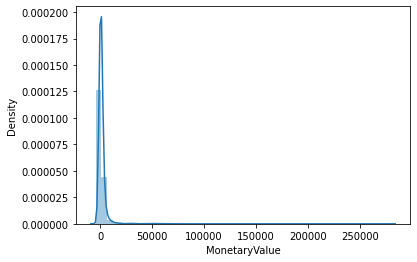

In [152]:
sns.distplot(datamart_rfm['MonetaryValue'])
plt.show()

In [153]:
datamart_sqrt = np.sqrt(datamart_rfm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [154]:
datamart_sqrt.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,18.055470,1.414214,0.000000
12347,1.414214,13.490738,65.650590
12348,8.660254,5.567764,42.393867
12349,4.358899,8.544004,41.923144
12350,17.606817,4.123106,18.286607


In [155]:
datamart_sqrt.describe()

,Recency,Frequency,MonetaryValue
count,4372.000000,4372.000000,4329.000000
mean,8.145637,7.822424,32.987230
std,5.069673,5.645375,28.851482
min,1.000000,1.000000,0.000000
25%,4.123106,4.123106,17.350216
50%,7.071068,6.480741,25.625768
75%,11.958261,10.099505,40.301489
max,19.339080,89.347636,528.667211


In [156]:
datamart_sqrt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4372 entries, 12346 to 18287
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        4372 non-null   float64
 1   Frequency      4372 non-null   float64
 2   MonetaryValue  4329 non-null   float64
dtypes: float64(3)
memory usage: 136.6+ KB


In [125]:
print(datamart_sqrt.skew(axis = 0))
print(datamart_sqrt.kurtosis(axis = 0))

Recency          0.592223
Frequency        3.203886
MonetaryValue    5.808060
dtype: float64
Recency          -0.759048
Frequency        25.814760
MonetaryValue    64.702426
dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


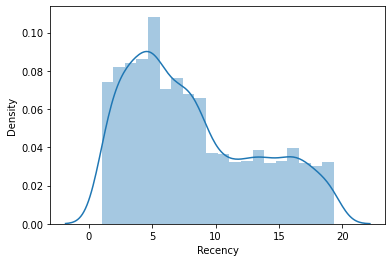

In [126]:
sns.distplot(datamart_sqrt['Recency'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


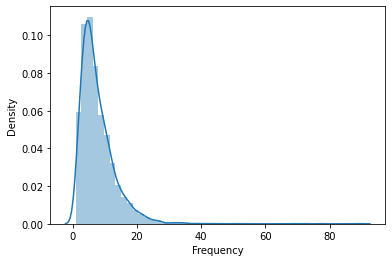

In [127]:
sns.distplot(datamart_sqrt['Frequency'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


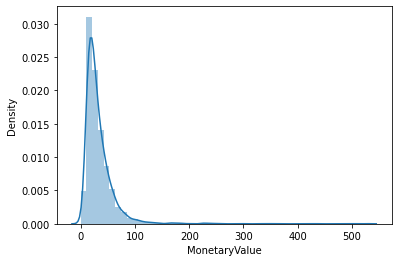

In [128]:
sns.distplot(datamart_sqrt['MonetaryValue'])

In [157]:
datamart_sqrt['MonetaryValue'] = datamart_sqrt['MonetaryValue'].fillna(datamart_sqrt['MonetaryValue'].mean())

In [158]:
datamart_sqrt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4372 entries, 12346 to 18287
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        4372 non-null   float64
 1   Frequency      4372 non-null   float64
 2   MonetaryValue  4372 non-null   float64
dtypes: float64(3)
memory usage: 136.6+ KB


### Centering and scaling

We will use the existin Standard Sclare Tool to deal with this

In [159]:
scaler = StandardScaler()

In [160]:
scaler.fit(datamart_sqrt)
datamart_normalized = scaler.transform(datamart_sqrt)

## Select the model

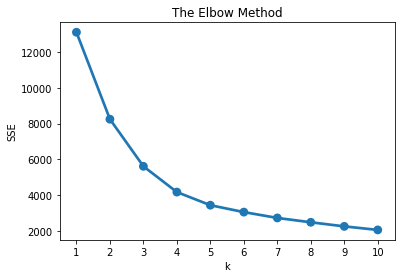

In [168]:
#Using the elbow method we are going to assing the numbers of clusters
sse = {}

for i in range(1,11):
  kmeans = KMeans(n_clusters = i,random_state = 1)
  kmeans.fit(datamart_normalized)
  sse[i] =kmeans.inertia_ #  sum of squared distances to closest cluster center

plt.title("The Elbow Method")
plt.xlabel('k');plt.ylabel('SSE')
sns.pointplot(x = list(sse.keys()),y=list(sse.values()))
plt.show()

## Running the model

In [174]:
#Configure the model
kmeans = KMeans(n_clusters = 3,random_state = 2)

In [175]:
#Fit the model
kmeans.fit(datamart_normalized)

KMeans(n_clusters=3, random_state=2)

In [176]:
#Extract clusters from the model
cluster_labels = kmeans.labels_

In [177]:
#Create a custom label in the original dataset
datamart_rfm_k3 = datamart_rfm.assign(Cluster = cluster_labels)

In [178]:
datamart_rfm_k3.groupby(['Cluster']).agg({'Recency': 'mean','Frequency': 'mean','MonetaryValue': ['mean','count'],}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          38.0      61.0        1001.0  2456
1          19.0     374.0        8885.0   593
2         225.0      27.0         433.0  1323

# Evaluate the model using BI

# Snake Plot

In [179]:
datamart_normalized = pd.DataFrame(datamart_normalized,index = datamart_rfm.index,columns = datamart_rfm.columns)
datamart_normalized['Cluster'] = datamart_rfm_k3['Cluster']

In [180]:
datamart_melt = pd.melt(datamart_normalized.reset_index(),
                        id_vars=['CustomerID','Cluster'],
                        value_vars =['Recency','Frequency','MonetaryValue'],
                        var_name = 'Attribute',
                        value_name = 'Value')

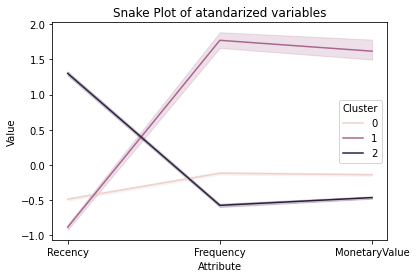

In [181]:
plt.title("Snake Plot of atandarized variables")
sns.lineplot(x = "Attribute", y = "Value", hue = "Cluster", data = datamart_melt)

## Relative importance of segments attributes

In [182]:
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean()
population_avg = datamart_rfm.mean()
relative_imp = cluster_avg /population_avg -1

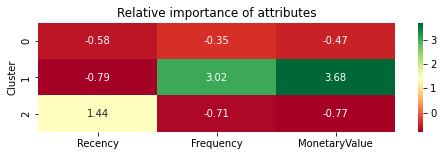

In [184]:
plt.figure(figsize = (8,2))
plt.title("Relative importance of attributes")
sns.heatmap(data =relative_imp,annot = True, fmt = '.2f', cmap = 'RdYlGn')
plt.show()